# Step 1: Cargando los datos y las librerías

"Sobre Cocinar Pizzas"

Success is a lousy teacher. It seduces smart people into thinking they can't lose.
 --- Bill Gates

In [ ]:
# Limpiamos el entorno
rm(list = ls())
gc(verbose = FALSE)

In [2]:
# Librerías necesarias
require("data.table")
require("rpart")
require("ggplot2")
require("ROCR")
require("lubridate")
require("lhs")
require("DiceKriging")
require("mlrMBO")

Loading required package: data.table

Loading required package: rpart

Loading required package: ggplot2

Loading required package: ROCR

Loading required package: lubridate


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: lhs

Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.


Attaching package: 'mlr'


The following object is masked from 'package:ROCR':

    performance


Loading required package: 

In [3]:
# Aqui se debe poner la carpeta de la materia de SU computadora local
setwd("C:/Users/German/Desktop/dmeyf2023/German/Clase 1") # Establezco el Working Directory

# Poner sus semillas
semillas <- c(279511, 279523, 279541, 279551, 279571)

In [5]:
# Cargamos el dataset
dataset <- fread("competencia_01.csv")

# Nos quedamos solo con el 202103
dataset <- dataset[foto_mes == 202103]

In [6]:
# Creamos una clase binaria
dataset[, clase_binaria := ifelse(
                            clase_ternaria == "BAJA+2",
                                "evento",
                                "noevento"
                            )]
# Borramos el target viejo
dataset[, clase_ternaria := NULL]

In [7]:
# Seteamos nuestra primera semilla
set.seed(semillas[1])

# Particionamos de forma estratificada
in_training <- caret::createDataPartition(dataset$clase_binaria,
                     p = 0.70, list = FALSE)
dtrain  <-  dataset[in_training, ]
dtest   <-  dataset[-in_training, ]

# Step 2: Nuestra pizza: Un modelo

In [8]:
# Calculamos cuanto tarda un modelo "promedio" entrenar.
start_time <- Sys.time()
modelo <- rpart(clase_binaria ~ .,
                data = dtrain,
                xval = 0,
                cp = 0,
                minsplit = 20,
                minbucket = 10,
                maxdepth = 10)
pred_testing <- predict(modelo, dtest, type = "prob")
end_time <- Sys.time()
model_time <- end_time - start_time
print("Tiempo de ajuste en train y predict en test")
print(model_time)

ganancia <- function(probabilidades, clase) {
  return(sum(
    (probabilidades >= 0.025) * ifelse(clase == "evento", 273000, -7000))
  )
}

print("La ganancia NORMALIZADA de nuestro modelo es:")
print(ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3)

[1] "Tiempo de ajuste en train y predict en test"
Time difference of 7.745408 secs
[1] "La ganancia NORMALIZADA de nuestro modelo es:"
[1] 71726667


**Preguntas**
- ¿Es acaso este el mejor modelo posible?
- ¿Dónde lo buscamos el mejor modelo?
- ¿Qué parámetros conoce para un árbol de decisión?
- ¿Qué espacios de búsqueda tienen los parámetros *maxdepth* y *minsplit*?
- ¿Cómo se imagina la interacción entre esto dos últimos parámetros?

# Step 3: There Ain't No Such Thing As A Free Lunch

In [9]:
# Supongamos que sólo vamos a buscar sobre los parámetros *maxdepth* y
# *minsplit*

# Tamaño del espacio de búsqueda de *maxdepth*
n_md <- 30 - 4
# Tamaño del espacio de búsqueda de *minsplit*
n_ms <- 200 - 2
# Cantidad de semillas
n_seeds <- 5

# Estimación de cuanto tardaría en buscar el mejor modelo con 2 parámetros.
print(seconds_to_period(n_md * n_ms * n_seeds * model_time))

# Tamaño del espacio de búsqueda de *minbucket*
n_mb <- 100 - 2

# Estimación de cuanto tardaría en buscar el mejor modelo con 3 parámetros.
print(seconds_to_period(n_md * n_ms * n_seeds * model_time * n_mb))

[1] "2d 7H 22M 46.8034172058105S"
[1] "226d 3H 12M 26.7348861694336S"


**Preguntas**
- ¿Dispone del tiempo para realizar esta búsqueda?
- ¿Qué hacemos cuándo un parámetro tiene valores continuos?

# Step 4: Empezando a probar con menos casos

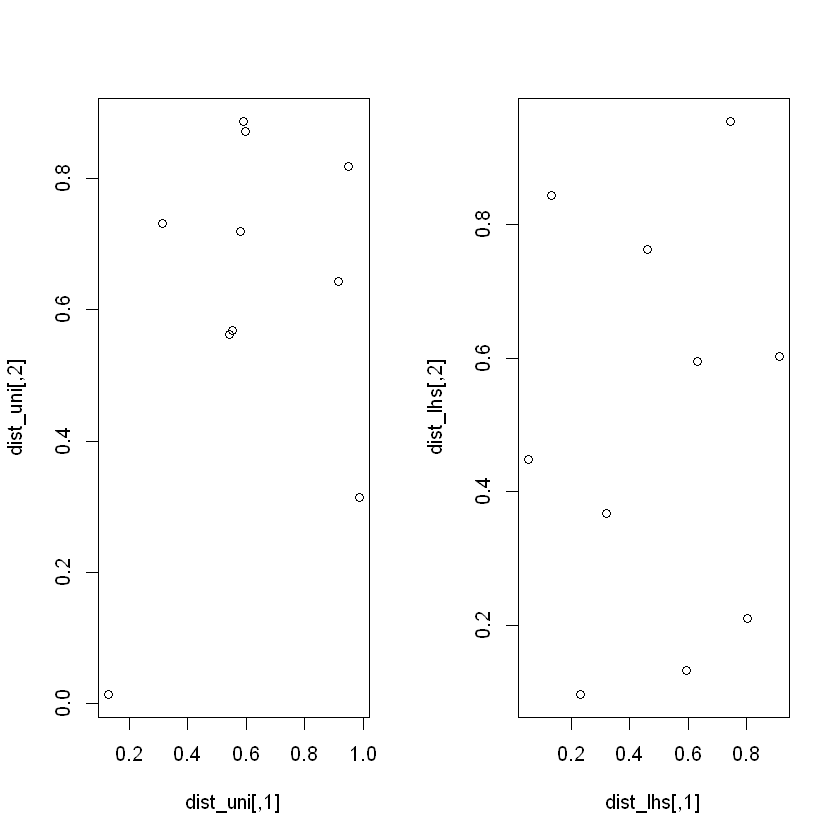

In [10]:
set.seed(semillas[1])
dist_uni <- matrix(runif(20), 10, 2)

# LHS Latin hypercube sampling
set.seed(semillas[1])
dist_lhs <- optimumLHS(10, 2)

par(mfrow = c(1, 2))
plot(dist_uni)
plot(dist_lhs)

**Preguntas**
- ¿Cuál distribución considera mejor? Justifique

# Step 5: "Tomando una muestra de sangre"

In [11]:
# Armamos una función para modelar con el fin de simplificar el código futuro
modelo_rpart <- function(train, test, cp =  0, ms = 20, mb = 1, md = 10) {
    modelo <- rpart(clase_binaria ~ ., data = train,
                    xval = 0,
                    cp = cp,
                    minsplit = ms,
                    minbucket = mb,
                    maxdepth = md)

    test_prediccion <- predict(modelo, test, type = "prob")
    roc_pred <-  ROCR::prediction(test_prediccion[, "evento"],
                    test$clase_binaria,
                                  label.ordering = c("noevento", "evento"))
    auc_t <-  ROCR::performance(roc_pred, "auc")

    unlist(auc_t@y.values)
}

In [12]:
# Función para tomar un muestra dejando todos los elementos de la clase BAJA+2
tomar_muestra <- function(datos, resto = 10000) {
      t <- datos$clase_binaria == "evento"
      r <- rep(FALSE, length(datos$clase_binaria))
      r[!t][sample.int(resto, n = (length(t) - sum(t)))] <- TRUE
      t | r
}

In [13]:
set.seed(semillas[1])
ds_sample <- tomar_muestra(dataset)
table(dataset[ds_sample]$clase_binaria)



  evento noevento 
    1049    10000 

**Preguntas**
- ¿Qué tipo de muestre se tomó?
- ¿Hay mejores formas de muestrear?
- ¿Es bueno muestrear?
- ¿Qué efectos en las métricas va a producir el muestreo?
- ¿Por qué se eligió usar el AUC?
- ¿Qué hay que cambiar en la función de ganancia para poder utilizarla?

# Step 6: Comparando tiempos con o sin muestras

In [14]:
t0 <- Sys.time()
r1 <- modelo_rpart(dtrain, dtest)
t1 <- Sys.time()
print("Train entero")
print(t1 - t0)
print(r1)

[1] "Train entero"
Time difference of 8.149401 secs
[1] 0.8767164


In [15]:
set.seed(semillas[1])
dtrain_sample <- tomar_muestra(dtrain)

In [16]:
t0 <- Sys.time()
r2 <- modelo_rpart(dtrain[dtrain_sample, ], dtest)
t1 <- Sys.time()
print("Muestra train")
print(t1 - t0)
print(r2)

[1] "Muestra train"
Time difference of 0.8057709 secs
[1] 0.8582668


Preguntas
- ¿Por qué sólo se muestrea train?

# Step 7: Buscando el mejor modelo con muestras aleatorias LHS

In [17]:
# Una función auxiliar para los experimentos
experimento_rpart <- function(ds, semillas, cp = 0, ms = 20, mb = 1, md = 10) {
  auc <- c()
  for (s in semillas) {
    set.seed(s)
    in_training <- caret::createDataPartition(ds$clase_binaria, p = 0.70,
        list = FALSE)
    train  <-  ds[in_training, ]
    test   <-  ds[-in_training, ]
    train_sample <- tomar_muestra(train)
    r <- modelo_rpart(train[train_sample,], test, 
                    cp = cp, ms = ms, mb = mb, md = md)
    auc <- c(auc, r)
  }
  mean(auc)
}

    md  ms       auc
 1: 12  54 0.8711736
 2: 18  79 0.8700500
 3:  6 150 0.8759515
 4: 16 188 0.8817030
 5:  5 183 0.8638452
 6: 13 139 0.8807381
 7:  9  20 0.8658259
 8: 18 132 0.8773719
 9:  8  36 0.8724344
10:  4  30 0.8488628
11: 12 112 0.8790455
12: 10 128 0.8805852
13:  6  11 0.8731927
14:  7  67 0.8774589
15:  9  95 0.8817945
16: 17  64 0.8683098
17: 11  89 0.8792865
18: 14  43 0.8578880
19: 15 154 0.8804674
20: 11 166 0.8818118
21: 14 117 0.8782123
22: 13 170 0.8802753
23: 16   8 0.7318961
24:  4 100 0.8492096
25:  7 194 0.8770694
    md  ms       auc


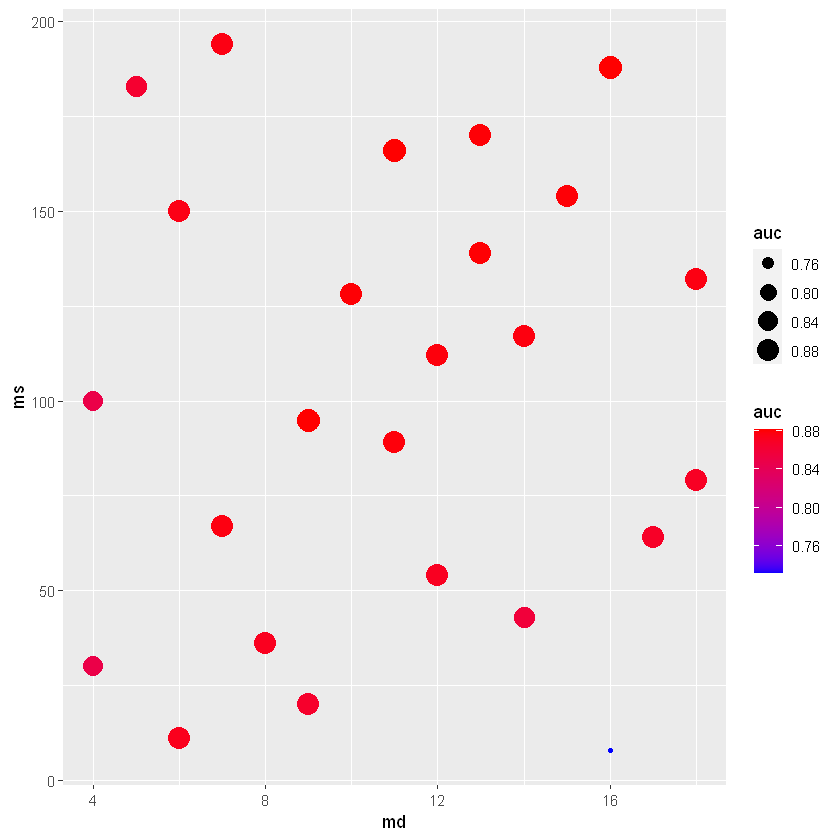

In [18]:
# Haremos 25 experimentos aleatorios, armamos las muestras de acuerdo a como
# son las entradas de nuestro experimento.

set.seed(semillas[1])
cantidad_puntos <- 25
espacio_busqueda_1 <- optimumLHS(cantidad_puntos, 2)

# la primera columna es para el maxdepth, y la segunda para el minslip
espacio_busqueda_1[, 1] <- floor(15 * espacio_busqueda_1[, 1]) + 4
espacio_busqueda_1[, 2] <- floor(200 * espacio_busqueda_1[, 2]) + 2

resultados_random_search <- data.table()
for (e in 1:cantidad_puntos) {
  r <- experimento_rpart(dataset, semillas,
                        ms = espacio_busqueda_1[e, 2],
                        md = espacio_busqueda_1[e, 1])
  resultados_random_search <- rbindlist(list(resultados_random_search,
                  data.table(
                    md = espacio_busqueda_1[e, 1],
                    ms = espacio_busqueda_1[e, 2],
                    auc = r)
  ))
}

print(resultados_random_search)
ggplot(resultados_random_search, aes(x = md, y = ms, color = auc)) +
    scale_color_gradient(low = "blue", high = "red") +
    geom_point(aes(size = auc))

Preguntas
- ¿Hay alguna zona dónde parece que hay más ganancia?
- ¿Cómo podemos continuar nuestra búsqueda?

# Step 8: Trabajando con herramientas más profesionales


In [ ]:
# Veamos un ejemplo
set.seed(semillas[1])
obj_fun <- makeSingleObjectiveFunction(
  name = "Sine",
  fn = function(x) sin(x),
  par.set = makeNumericParamSet(lower = 3, upper = 13, len = 1)
)

ctrl <- makeMBOControl()
ctrl <- setMBOControlTermination(ctrl, iters = 10L)
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI(),
                           opt = "focussearch")

lrn <- makeMBOLearner(ctrl, obj_fun)
design <- generateDesign(6L, getParamSet(obj_fun), fun = lhs::maximinLHS)

run <- exampleRun(obj_fun, design = design, learner = lrn,
                 control = ctrl, points.per.dim = 100, show.info = TRUE)

In [ ]:
# Ejecutar de a uno
plotExampleRun(run, iters = 1, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 2, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 3, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 5, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 6, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 7, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 8, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 9, densregion = TRUE, pause = FALSE)
plotExampleRun(run, iters = 10, densregion = TRUE, pause = FALSE)

# Step 9: Introduciendo la técnica en nuestro conjunto

In [ ]:
resultados_maxdepth <- data.table()

for (v in 4:20) {
    r <- data.table(
      md = v,
      auc = experimento_rpart(dataset, semillas, md = v)
    )
    resultados_maxdepth <- rbindlist(list(resultados_maxdepth, r))
}

ggplot(resultados_maxdepth, aes(md, auc)) + geom_point()

# Step 10: Buscando con una Opt. Bayesiana para 1 parámetro

In [ ]:
et.seed(semillas[1])
obj_fun_md <- function(x) {
  experimento_rpart(dataset, semillas, md = x$maxdepth)
}

obj_fun <- makeSingleObjectiveFunction(
  minimize = FALSE,
  fn = obj_fun_md,
  par.set = makeParamSet(
    makeIntegerParam("maxdepth",  lower = 4L, upper = 20L)
  ),
  # noisy = TRUE,
  has.simple.signature = FALSE
)

ctrl <- makeMBOControl()
ctrl <- setMBOControlTermination(ctrl, iters = 10L)
ctrl <- setMBOControlInfill(
  ctrl,
  crit = makeMBOInfillCritEI(),
  opt = "focussearch",
  opt.focussearch.points = 2
)

In [ ]:
lrn <- makeMBOLearner(ctrl, obj_fun)

surr_km <- makeLearner("regr.km", predict.type = "se", covtype = "matern3_2")

run_md <- mbo(obj_fun, learner = surr_km, control = ctrl)
print(run_md)

# Step 11: Buscando con una Opt. Bayesiana para 2 parámetros

In [ ]:
set.seed(semillas[1])
obj_fun_md_ms <- function(x) {
  experimento_rpart(dataset, semillas
            , md = x$maxdepth
            , ms = x$minsplit)
}

obj_fun <- makeSingleObjectiveFunction(
  minimize = FALSE,
  fn = obj_fun_md_ms,
  par.set = makeParamSet(
    makeIntegerParam("maxdepth",  lower = 4L, upper = 20L),
    makeIntegerParam("minsplit",  lower = 1L, upper = 200L)
    # makeNumericParam <- para parámetros continuos
  ),
  # noisy = TRUE,
  has.simple.signature = FALSE
)

ctrl <- makeMBOControl()
ctrl <- setMBOControlTermination(ctrl, iters = 16L)
ctrl <- setMBOControlInfill(
  ctrl,
  crit = makeMBOInfillCritEI(),
  opt = "focussearch",
  # sacar parámetro opt.focussearch.points en próximas ejecuciones
  opt.focussearch.points = 20
)

In [ ]:
lrn <- makeMBOLearner(ctrl, obj_fun)

surr_km <- makeLearner("regr.km", predict.type = "se", covtype = "matern3_2")

In [ ]:
run_md_ms <- mbo(obj_fun, learner = surr_km, control = ctrl, )
print(run_md_ms)

In [ ]:
## Visualizamos
iter <- as.data.frame(run_md_ms$opt.path)
ggplot(iter, aes(y=minsplit,x=maxdepth, color=prop.type)) + geom_point(aes(size = y))